In [11]:
import time
import matplotlib.pyplot as plt

### Функція, яка отримує дані з файлу

In [12]:
def read_data(path):
    with open(path, 'r', encoding = 'utf-8') as file:
        data = file.read()
    return data

array_start = list(read_data('data/data_10000.txt'))

# Алгоритм LZW

### Реалізація самого алгоритму.
<code>lzw_compress</code> - стиснення
<br><code>lzw_decompress</code> - розшифрування

In [13]:
class Lzw:
    def __init__(self, array):
        self.array = array
        self.dictionary = self.make_dict(self.array)
        self.code = self.lzw_compress(self.array, self.dictionary)
        self.decoded = self.lzw_decompress(self.code, self.dictionary)

    def make_dict(self, array):
        array_set = sorted(list(set(array)))
        muneric = list(range(len(array_set)))
        return dict(zip(array_set, muneric))

    def lzw_compress(self, array, dictionary):
        code = []
        current, following = array[0], array[1]
        for idx in range(1, len(array)):
            len_d = len(dictionary)
            string = current+following
            counter = 1
            if string not in dictionary:
                code.append(str(dictionary[current]))
                dictionary[string] = len_d
                current = array[idx]
                try:
                    following = array[idx+1]
                except IndexError:
                    code.append(str(dictionary[current]))
            else:
                current = string
                try:
                    following = array[idx+counter]
                    counter += 1
                except IndexError:
                    code.append(str(dictionary[current]))
        return ' '.join(code)

    def lzw_decompress(self, code, dictionary):
        key_list = list(dictionary.keys())
        val_list = list(dictionary.values())
        decoded = []
        for symbol in code.split():
            decoded.append(key_list[val_list.index(int(symbol))])
        return ''.join(decoded)

### Запис у файл

In [14]:
a = Lzw(list(read_data('data/data_10000.txt')))

with open('data/lzw_code.txt', 'w', encoding = 'utf-8') as file:
    file.write(a.code)

with open('data/lzw_dec.txt', 'w', encoding = 'utf-8') as file:
    file.write(a.decoded)

In [15]:
if __name__ == "__main__":
    time_code = []
    value = []
    for i in range(10, 10000):
        array_start = list(read_data('data/data_10000.txt'))[:i]
        a = Lzw(array_start)
        start = time.time()
        encode = a.lzw_compress
        decode = a.lzw_decompress
        finish = time.time() - start
        time_code.append(finish)
        value.append(i)

### Графік на основі даних 10-10000.
X - довжина даних
<br> Y - час


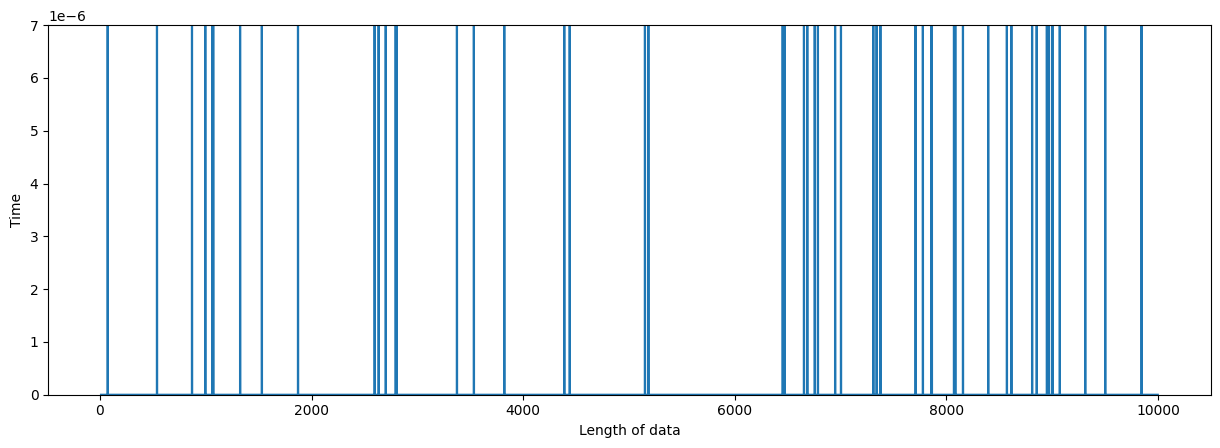

In [16]:
plt.figure().set_figwidth(15)
plt.plot(value, time_code)
plt.ylim(0, 0.000007)
plt.xlabel('Length of data')
plt.ylabel('Time')
plt.show()


### Оцінка стистення алгоритму

In [20]:
a = Lzw(array_start)
encode = a.lzw_compress

print(f"Довжина початкового: {len(array_start)}")
print(f"Довжина стиснутого: {len(a.code.split(' '))}")
print(f"Ступінь стиснення: {(1-(len(a.code.split(' '))/len(array_start))) * 100}% ")

a = Lzw(array_start[:500])
encode = a.lzw_compress

print(f"Довжина початкового: {len(array_start)}")
print(f"Довжина стиснутого: {len(a.code.split(' '))}")
print(f"Ступінь стиснення: {(1-(len(a.code.split(' '))/len(array_start))) * 100}% ")

a = Lzw(array_start[:100])
encode = a.lzw_compress

print(f"Довжина початкового: {len(array_start)}")
print(f"Довжина стиснутого: {len(a.code.split(' '))}")
print(f"Ступінь стиснення: {(1-(len(a.code.split(' '))/len(array_start))) * 100}% ")

a = Lzw(array_start[:10])
encode = a.lzw_compress

print(f"Довжина початкового: {len(array_start)}")
print(f"Довжина стиснутого: {len(a.code.split(' '))}")
print(f"Ступінь стиснення: {(1-(len(a.code.split(' '))/len(array_start))) * 100}% ")

Довжина початкового: 1000
Довжина стиснутого: 376
Ступінь стиснення: 62.4% 
Довжина початкового: 1000
Довжина стиснутого: 212
Ступінь стиснення: 78.8% 
Довжина початкового: 1000
Довжина стиснутого: 59
Ступінь стиснення: 94.10000000000001% 
Довжина початкового: 1000
Довжина стиснутого: 9
Ступінь стиснення: 99.1% 


По графіку можна побачити, що час виконання алгоритму зростає до 1500 символів. Далі йде більш-менш стабільно. Алгоритм ефективно стискає дані та доволі швидкий. Слкадність алгоритму - O(n)

# Алгоритм LZ77

### Реалізація самого алгоритму.
<code>lz77_compress</code> - стиснення
<br><code>lz77_decompress</code> - розшифрування

In [21]:
class Lz77:
    def __init__(self, array, buffer):
        self.array = array
        self.buffer = buffer
        self.code = self.lz77_compress(self.array, self.buffer)
        self.decoded = self.lz77_decompress(self.code)

    def lz77_compress(self, array, buffer):
        code = []
        border = 0
        while border < len(self.array):
            offset, length = 0, 0
            for iter_buffer in range(border):
                step = 0
                while step < self.buffer and border + step < len(self.array) and self.array[iter_buffer + step] == self.array[border + step]:
                    step += 1
                if step > length:
                    offset = border - iter_buffer
                    length = step
            if length == 0:
                code.append((0, 0, self.array[border]))
                border += 1
            else:
                next_symbol = self.array[border + length] if border + length < len(self.array) else ''
                code.append((offset, length, next_symbol))
                border += length + 1
        return code

    def lz77_decompress(self, code):
        decoded = ''
        for element in self.code:
            offset, length, symbol = element[0], element[1], element[2]
            if length != 0:
                start = len(decoded) - offset
                for i in range(length):
                    decoded += decoded[start + i]
            decoded += symbol
        return decoded

### Запис у файл

In [22]:
a = Lz77(list(read_data('data/data_10000.txt')), 15)
print
with open('data/lz77_code.txt', 'w', encoding = 'utf-8') as file:
    coded = a.code
    for i in coded:
        file.write(str(i))

with open('data/lz77_dec.txt', 'w', encoding = 'utf-8') as file:
    file.write(a.decoded)

In [23]:
if __name__ == "__main__":
    time_code = []
    value = []
    for i in range(10, 10000, 10):
        array_start = array_start = list(read_data('data/data_10000.txt'))[:i]
        a = Lz77(array_start, 15)
        start = time.time()
        encode = a.lz77_compress
        decode = a.lz77_decompress
        finish = time.time() - start
        time_code.append(finish)
        value.append(i)

### Графік на основі даних 10-10000.
X - довжина даних
<br> Y - час


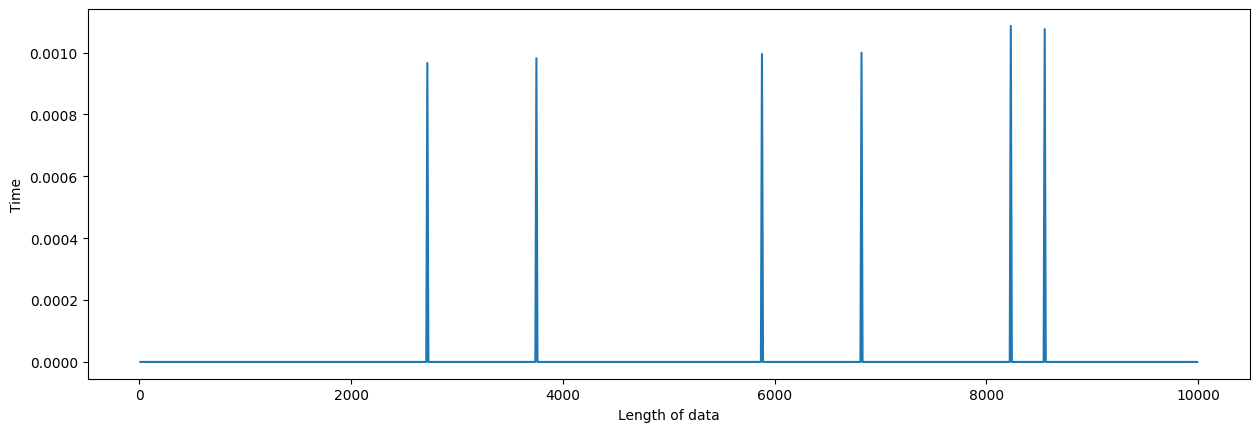

In [25]:
plt.figure().set_figwidth(15)
plt.plot(value, time_code)
plt.xlabel('Length of data')
plt.ylabel('Time')
plt.show()

### Оцінка стистення алгоритму

In [27]:
a = Lz77(array_start, 15)
encode = a.lz77_compress
print(f"Довжина початкового: {len(array_start)}")
print(f"Довжина стиснутого: {len(a.code)*3}")
print(f"Ступінь стиснення: {(1-((len(a.code)*3)/len(array_start))) * 100}% ")

a = Lz77(array_start[:500], 15)
encode = a.lz77_compress
print(f"Довжина початкового: {len(array_start)}")
print(f"Довжина стиснутого: {len(a.code)*3}")
print(f"Ступінь стиснення: {(1-((len(a.code)*3)/len(array_start))) * 100}% ")

a = Lz77(array_start[:100], 15)
encode = a.lz77_compress
print(f"Довжина початкового: {len(array_start)}")
print(f"Довжина стиснутого: {len(a.code)*3}")
print(f"Ступінь стиснення: {(1-((len(a.code)*3)/len(array_start))) * 100}% ")

a = Lz77(array_start[:10], 15)
encode = a.lz77_compress
print(f"Довжина початкового: {len(array_start)}")
print(f"Довжина стиснутого: {len(a.code)*3}")
print(f"Ступінь стиснення: {(1-((len(a.code)*3)/len(array_start))) * 100}% ")

Довжина початкового: 1000
Довжина стиснутого: 690
Ступінь стиснення: 31.000000000000007% 
Довжина початкового: 1000
Довжина стиснутого: 387
Ступінь стиснення: 61.3% 
Довжина початкового: 1000
Довжина стиснутого: 105
Ступінь стиснення: 89.5% 
Довжина початкового: 1000
Довжина стиснутого: 21
Ступінь стиснення: 97.89999999999999% 


По графіку можна побачити, що час виконання алгоритму також зростає до 1500 символів. Далі йде більш-менш стабільно. Алгоритм менш ефективний, ніж lzw, стискає дані гірше та повільніший. Слкадність алгоритму - O(n^2)

# Алгоритм Гаффмана

In [28]:
class huffman():
    """Huffman class which has huffman_compress, huffman_decompress and make_dict methods"""
    def __init__(self, message) -> None:
        """The class constructor, stores the received message and analyzes it, creating the code dictionary for it"""
        self.message = message
        self.dictionary = self.make_dict()

    def make_dict(self):
        """"Analyzes the received class message, creating a code dict from it. Compares the frequencies and using Huffman method assigns
        each unique character a corresponding code"""
        characters = sorted([[ch,self.message.count(ch)] for ch in set(self.message)], key = lambda x: x[1])
        dictionary = {ch: "" for ch in set(self.message)}
        while len(characters)!=1:
            for i in characters[0][0]:
                dictionary[i] += '0'
            for i in characters[1][0]:
                dictionary[i] += '1'
            characters.append([characters[0][0]+characters[1][0], characters[0][1]+characters[1][1]])
            characters = characters[2:]
            characters = sorted(characters, key = lambda x : x[1])
        dictionary = {ch: value[::-1] for ch,value in dictionary.items()}
        return dictionary

    def huffman_compress(self):
        """ Encodes the class received message, replaces all characters with their corresponding codes, sadly does this in string format"""
        message = []
        for i in self.message:
            message.append(self.dictionary[i])
        return " ".join(message)

    def huffman_decompess(self, encoded: str):
        """Receives a message that has been encoded with huffman_compress and decodes it into string"""
        encoded = encoded.split()
        dictionary = {value: ch for ch,value in self.dictionary.items()}
        for ind, val in enumerate(encoded):
            encoded[ind] = dictionary[val]
        return "".join(encoded)

In [29]:
#Let`s compare whether our original file and the encoded then decoded file are the same by storing the decoded version in another file`
a = huffman(read_data('data/data.txt'))

encoded = a.huffman_compress()
decoded = a.huffman_decompess(encoded)
with open('data/huffman_dec.txt', 'w', encoding = 'utf-8') as file:
    file.write(decoded)

In [30]:
# Let's test our code on different amount of data
if __name__ == "__main__":
    time_code = []
    value = []
    for i in range(10, 10000):
        array_start = list(read_data('data/data.txt'))[:i]
        a = huffman(array_start)
        start = time.time()
        encode = a.huffman_compress()
        decode = a.huffman_decompess(encode)
        finish = time.time() - start
        time_code.append(finish)
        value.append(i)


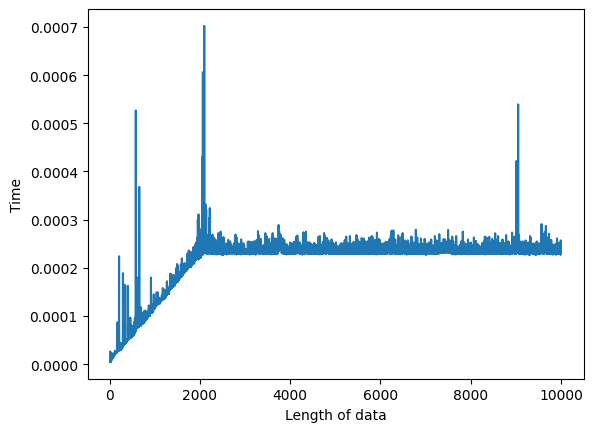

In [18]:
#And visualise it
import matplotlib.pyplot as plt
plt.plot(value, time_code)
plt.xlabel('Length of data')
plt.ylabel('Time')
plt.show()

In [20]:
array_start = list(read_data('data/data.txt'))
a = huffman(array_start)
encode = a.huffman_compress()
encoded_length = round(len("".join(encode.split()))/8)
print("Для всього файла")
# As we have worked with srings, for us to count how the real Huffman algorithm would work with our code dictionary ,we have to
# get rid of all the spaces in our encoded message and divide it by 8, as that would be the nuber of bytes it would take to store such a message
print(f"Довжина початкового: {len(array_start)} байт")
print(f'Довжина кінцевого : {encoded_length} байт')
print(f"Ступінь стиснення: {(1-encoded_length/len(array_start)) * 100}% ")

array_start = list(read_data('data/data.txt'))[:1000]
a = huffman(array_start)
encode = a.huffman_compress()
encoded_length = round(len("".join(encode.split()))/8)
print("Стиснення для 1000 символів")
# As we have worked with srings, for us to count how the real Huffman algorithm would work with our code dictionary ,we have to
# get rid of all the spaces in our encoded message and divide it by 8, as that would be the nuber of bytes it would take to store such a message
print(f"Довжина початкового: {len(array_start)} байт")
print(f'Довжина кінцевого : {encoded_length} байт')
print(f"Ступінь стиснення: {(1-encoded_length/len(array_start)) * 100}% ")

array_start = list(read_data('data/data.txt'))[:500]
a = huffman(array_start)
encode = a.huffman_compress()
encoded_length = round(len("".join(encode.split()))/8)
print("Стиснення для 500 символів")
# As we have worked with srings, for us to count how the real Huffman algorithm would work with our code dictionary ,we have to
# get rid of all the spaces in our encoded message and divide it by 8, as that would be the nuber of bytes it would take to store such a message
print(f"Довжина початкового: {len(array_start)} байт")
print(f'Довжина кінцевого : {encoded_length} байт')
print(f"Ступінь стиснення: {(1-encoded_length/len(array_start)) * 100}% ")

array_start = list(read_data('data/data.txt'))[:10]
a = huffman(array_start)
encode = a.huffman_compress()
encoded_length = round(len("".join(encode.split()))/8)
print("Стиснення для 10 символів")
# As we have worked with srings, for us to count how the real Huffman algorithm would work with our code dictionary ,we have to
# get rid of all the spaces in our encoded message and divide it by 8, as that would be the nuber of bytes it would take to store such a message
print(f"Довжина початкового: {len(array_start)} байт")
print(f'Довжина кінцевого : {encoded_length} байт')
print(f"Ступінь стиснення: {(1-encoded_length/len(array_start)) * 100}% ")

Для всього файла
Довжина початкового: 2081 байт
Довжина кінцевого : 1135 байт
Ступінь стиснення: 45.458913983661695% 
Стиснення для 1000 символів
Довжина початкового: 1000 байт
Довжина кінцевого : 546 байт
Ступінь стиснення: 45.4% 
Стиснення для 500 символів
Довжина початкового: 500 байт
Довжина кінцевого : 277 байт
Ступінь стиснення: 44.599999999999994% 
Стиснення для 10 символів
Довжина початкового: 10 байт
Довжина кінцевого : 4 байт
Ступінь стиснення: 60.0% 


Можна побачити, що час який витрачає алгоритм, приблизно однаковий для всіх довжин вхідних даних, також легко переконатися, що ступінь стиснення приблизно однаковий для різних даних. Складність алгоритму  - О(nlogn)

Висновок: Більшість алгоритмів працюють найкраще на малих вибірках, якщо треба брати дуже великі дані, найкращим залишається Lzw, далі Гаффмана, потім Lz77

Lz77 та Lzw - виконав Юрій Логін
Алгоритм Гаффмана - виконала Сидор Наталія